# Gaussian Process for HABs

We will fit a Gaussian Process to our dataset for the Area A, assuming it is a noisy signal with zero mean and standard deviation of 0.1. The mean function for the GP is the raw values for the area

In [6]:
import pandas as pd
data=pd.read_excel(r"C:\Users\gotta\OneDrive\Documents\Bureau\X\4A\US\Stanford\Classes\AA 222\Final Project\Data\Noisy_Samples.xlsx", engine='openpyxl')
data=pd.DataFrame(data)
data=data[['WLE_area_avg','WLE_CI_avg']]
mean_var=0.07



In [7]:
#Compute the DRP values that I have to send to the lab
#We use now the linear surrogate to solve for a linear system of equations
import numpy as np
A=np.array([[0.31838624,2.29792759],[0.00348731,0.04818059]])
b=np.array([742.21898475,15.344444752266575])
DRP_values=[]
for k in range (len(data)):
    area=data['WLE_area_avg'][k]
    CI=data['WLE_CI_avg'][k]
    b=np.array([742.21898475+area,15.344444752266575+CI])
    x=np.linalg.solve(A,b)
    DRP_values.append(x)
print(DRP_values)

            

[array([5742.95541438,    9.41129833]), array([5618.8603904 ,   26.60511604]), array([4588.52382955,   12.88567363]), array([4526.84857816,   21.43100442]), array([4269.84193702,  430.10784559]), array([4205.24218521,  439.05837657]), array([3025.9827673 ,  641.14926683]), array([2911.3177714 ,  657.03651979]), array([4390.88127079,  404.65919757]), array([4394.28381969,  404.18776202]), array([4500.15134065,   87.14366561]), array([4491.64465271,   88.32229822]), array([3557.78807979,  480.18579274]), array([3482.3057195 ,  490.64414877]), array([5698.14639632,   -7.18446149]), array([5464.68907661,   25.16190075]), array([4184.68174796,  464.0919602 ]), array([3913.16416424,  501.71171068]), array([5082.58019917,  209.51677839]), array([5079.41141221,  209.95582537]), array([5839.5555597 ,   51.16037918]), array([6123.57365534,   11.80863722]), array([nan, nan]), array([nan, nan])]


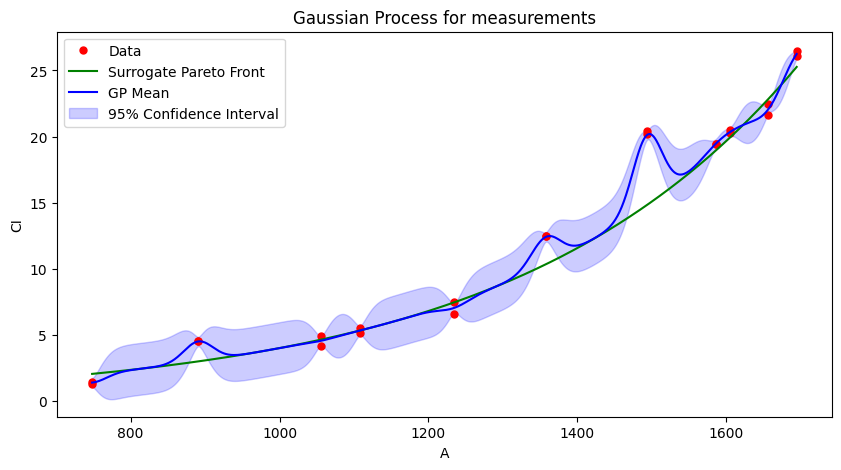

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
x = data['WLE_area_avg'].dropna()
y = data['WLE_CI_avg'].dropna()
x=np.array(x)
y=np.array(y)

def exponential_func(x, a=2.0563795986145132, b=2.5084178102007875, c=4.0539815053021915e-15):
    return a * np.exp(b * x) + c
x_fit_normalized = np.linspace(0, 1, 500)
y_fit = exponential_func(x_fit_normalized)
x_fit = x_fit_normalized * (np.max(x) - np.min(x)) + np.min(x)
#Incorporate the mean_var into the y_fit
x_normal=(x-np.min(x))/(np.max(x)-np.min(x))
y_th=exponential_func(x_normal)

# Create a Gaussian Process model
kernel = RBF(length_scale=10)
gp = GaussianProcessRegressor(kernel=kernel, alpha=mean_var)
# Fit to the data
y_gp=y-y_th
gp.fit(x.reshape(-1, 1), y_gp)
# Make predictions
x_pred = np.linspace(np.min(x), np.max(x), 1000).reshape(-1, 1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

# Correctly normalize x_pred for the exponential function
x_pred_normalized = (x_pred.flatten() - np.min(x)) / (np.max(x) - np.min(x))
y_pred_th = exponential_func(x_pred_normalized)

# Add the theoretical prediction
y_pred = y_pred + y_pred_th

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'r.', markersize=10, label='Data')
plt.plot(x_fit, y_fit, linestyle='-',label='Surrogate Pareto Front', color='green')
plt.plot(x_pred.flatten(), y_pred, 'b-', label='GP Mean')
plt.fill_between(x_pred.flatten(), y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, alpha=0.2, 
                 color='blue', label='95% Confidence Interval')
plt.xlabel('A')
plt.ylabel('CI')
plt.title('Gaussian Process for measurements')
plt.legend()
plt.show()

What would be intresting now is knowing where to evaluate next, performing Lower bound exploration. 

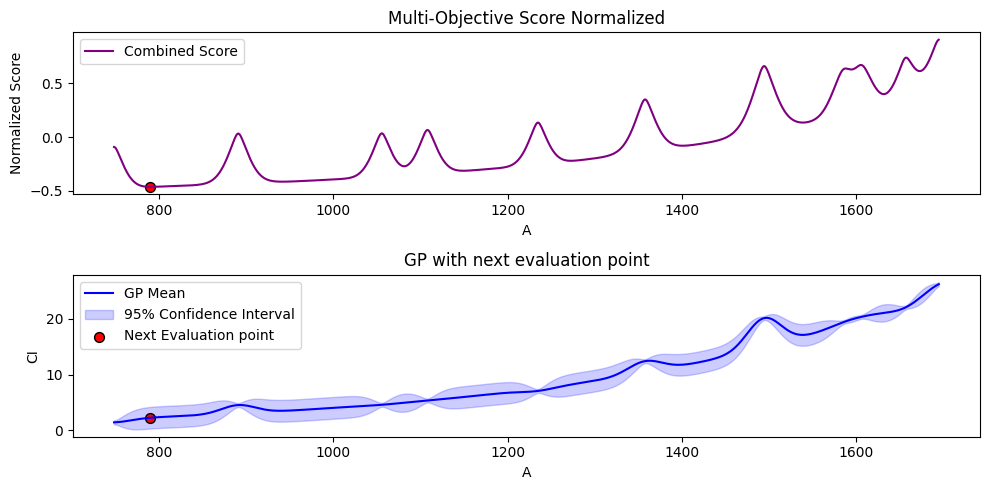

Multi-objective best point - Area: 789.99, Predicted CI: 2.229


In [9]:
alpha= 0.5  # Weight for area

# Normalize both metrics to 0-1 scale
normalized_CI = (y_pred.flatten() - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred))
normalized_uncertainty = sigma / np.max(sigma)

# Calculate score (higher is better)
scores = normalized_CI - alpha * normalized_uncertainty

# Find best point
best_idx = np.argmin(scores)
best_x = x_pred.flatten()[best_idx]
best_y = y_pred[best_idx]

plt.figure(figsize=(10, 5))

# Plot the score function
plt.subplot(2, 1, 1)
plt.plot(x_pred.flatten(), scores, color='purple', label='Combined Score')
plt.scatter(best_x, scores[best_idx], color='red', s=50, edgecolor='k')
plt.xlabel('A')
plt.ylabel('Normalized Score')
plt.title('Multi-Objective Score Normalized')
plt.legend()

# Plot the GP with the selected point
plt.subplot(2, 1, 2)
plt.plot(x_pred.flatten(), y_pred, 'b-', label='GP Mean')
plt.fill_between(x_pred.flatten(), y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, alpha=0.2, 
                 color='blue', label='95% Confidence Interval')
plt.scatter(best_x, best_y, color='red', s=50, edgecolor='k',
            label=f'Next Evaluation point')

plt.xlabel('A')
plt.ylabel('CI')
plt.title('GP with next evaluation point')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Multi-objective best point - Area: {best_x:.2f}, Predicted CI: {best_y:.3f}")

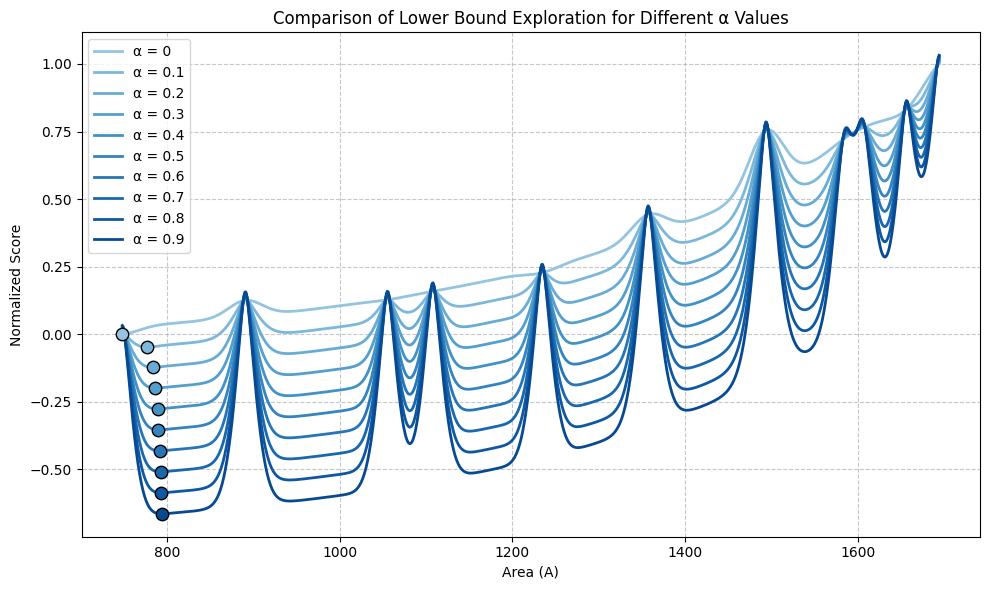

In [11]:
# Create a single plot comparing all alpha values
plt.figure(figsize=(10, 6))

# List of alpha values to compare
alpha_values = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create color gradient from light to dark blue
blues = plt.cm.Blues(np.linspace(0.4, 0.9, len(alpha_values)))

# Plot normalized score for each alpha
for i, alpha in enumerate(alpha_values):
    # Normalize both metrics to 0-1 scale
    normalized_CI = (y_pred.flatten() - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred))
    normalized_uncertainty = (sigma-np.min(sigma) / (np.max(sigma)-np.min(sigma)))
    
    # Calculate score (higher is better)
    scores = normalized_CI - alpha * normalized_uncertainty
    
    # Find best point
    best_idx = np.argmin(scores)
    best_x = x_pred.flatten()[best_idx]
    best_score = scores[best_idx]
    
    # Plot score curve
    plt.plot(x_pred.flatten(), scores, color=blues[i], 
             linewidth=2, label=f'α = {alpha}')
    
    # Mark best point
    plt.scatter(best_x, best_score, color=blues[i], s=80, 
                edgecolor='black', zorder=10)

# Add labels and title
plt.xlabel('Area (A)')
plt.ylabel('Normalized Score')
plt.title('Comparison of Lower Bound Exploration for Different α Values', fontsize=12)

# Add a legend
plt.legend(loc='best')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Improve aesthetics
plt.tight_layout()


plt.show()